# K Nearest Neighbours Classifier
In this notebook, I will be creating a K Nearest Neighbours classifier for the loan data. First, I will start with a baseline model and investigate the many ways this might be improved.

Make a simple model that can be used as the baseline to test against
List of improvements that could be made:
* Scaling data (using Z scores) to improve performance. This is because if some features are too large, they might "dominate the distance calculation and distort the cluster formation"
* Dimensionality reduction (pca/lda/t-sne/autoencoder/multidimensional scaling etc)due to the curse of dimensionality that knn has
* Selection of distance function
* Selection of K by cross validation
* Use ROC curves to evaluate your various models


In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

In [2]:
pd.set_option('display.max_columns', None)

loan_data = pd.read_csv("my_full_data.csv")
display(loan_data)

,Unnamed: 0,id,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
0,0,68387134,2500.0,0,17.27,89.47,3,1,1,50000.0,2,1,9,9,17.60,7.0,22.0,1,669.0,665.0,0,0.0
1,1,66615254,7200.0,0,17.27,257.67,3,9,4,20000.0,2,0,2,18,13.21,8.0,17.0,1,549.0,545.0,0,0.0
2,2,68376899,16000.0,0,10.78,522.16,1,5,5,63000.0,0,0,2,33,35.19,12.0,22.0,1,594.0,590.0,0,0.0
3,3,68366850,16000.0,0,5.32,481.84,0,8,1,96000.0,0,1,2,22,14.45,23.0,38.0,1,744.0,740.0,0,0.0
4,4,67195202,13000.0,1,16.59,320.23,3,10,5,40000.0,2,0,2,11,16.74,6.0,17.0,1,569.0,565.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26113,26113,90441274,12000.0,0,13.99,410.08,2,0,5,47000.0,1,1,1,25,31.79,13.0,28.0,0,754.0,750.0,0,0.0
26114,26114,90404436,25000.0,1,25.69,743.94,5,6,1,70000.0,2,0,9,5,15.10,9.0,19.0,0,499.0,0.0,0,0.0
26115,26115,90393111,16000.0,0,12.79,537.49,2,1,4,48000.0,0,1,2,4,33.60,11.0,17.0,0,699.0,695.0,0,0.0
26116,26116,90304259,35000.0,1,15.59,843.53,2,1,1,180000.0,2,1,2,9,13.09,17.0,31.0,0,714.0,710.0,0,0.0


## Baseline Model

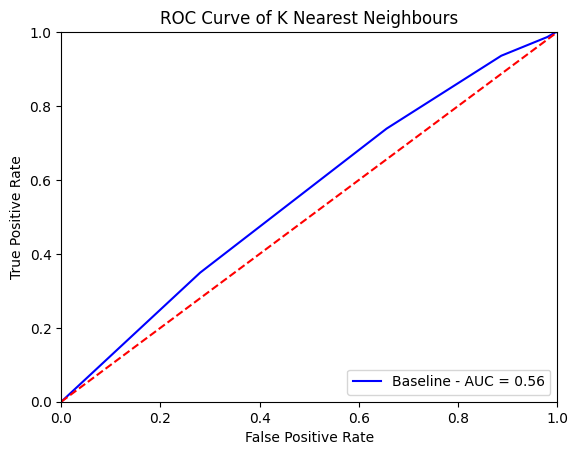

In [3]:
X = loan_data.drop(['loan_status', 'id'], axis=1)
y = loan_data['loan_status']

#Create training and test datasets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
y_pred_baseline = KNN.predict(X_test)
# print(classification_report(y_test, y_pred_baseline))
# print('Accuracy Score - KNN - Baseline:', metrics.accuracy_score(y_test, y_pred_baseline))  
y_scores=KNN.predict_proba(X_test)
fpr,tpr,threshold =roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

This ROC curve shows that our baseline model is essentially just as good as guessing randomly whether or nor a loan is approved or not.

## Standardisation

An initial avenue of exploration might be to scale/standarise the data set using Z scores. The resasoning behind this is that if some features are too large, they might have an outsized influence on the the distance calculation and interfer with how the clusters are formed. First, we look to see where the distribution of some columns in the the loan dataset are a lot larger than others. This might signfy that standardisation is prudent.  


In [4]:
X.describe()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
count,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,2.611800e+04,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000,26118.000000
mean,13058.500000,14713.151849,0.251359,13.294063,446.066954,1.756222,3.618616,2.913814,7.806945e+04,0.987442,2.688376,22.411019,18.179145,11.669845,25.057202,0.596294,676.627154,660.080596,0.020675,0.050425
std,7539.761502,8780.390798,0.433803,4.798467,263.632169,1.296153,3.181869,1.920452,6.676169e+04,0.774144,2.380318,14.756850,9.702454,5.507822,12.044223,0.490649,80.638253,130.432796,0.142298,0.354201
min,0.000000,1000.000000,0.000000,5.310000,28.690000,0.000000,0.000000,0.000000,3.500000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6529.250000,8000.000000,0.000000,9.750000,253.880000,1.000000,1.000000,1.000000,4.800000e+04,0.000000,2.000000,9.000000,11.690000,8.000000,16.000000,0.000000,629.000000,625.000000,0.000000,0.000000
50%,13058.500000,12800.000000,0.000000,12.790000,385.470000,2.000000,2.000000,4.000000,6.500000e+04,1.000000,2.000000,21.000000,17.560000,11.000000,23.000000,1.000000,694.000000,690.000000,0.000000,0.000000
75%,19587.750000,20000.000000,1.000000,16.020000,593.482500,3.000000,6.000000,5.000000,9.300000e+04,2.000000,2.000000,34.000000,23.860000,14.000000,32.000000,1.000000,734.000000,730.000000,0.000000,0.000000
max,26117.000000,40000.000000,1.000000,30.990000,1566.800000,6.000000,10.000000,5.000000,5.604824e+06,2.000000,13.000000,49.000000,446.050000,63.000000,110.000000,1.000000,850.000000,845.000000,1.000000,12.000000


We can see that some columns are orders of magnitudes larger than others and so we proceed with standarisation and compare the performance.

In [5]:
for column in X:
    X[column] = stats.zscore(X[column])

X.describe()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
count,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04,2.611800e+04
mean,-6.964505e-17,-8.596811e-17,-5.930711e-17,-2.916386e-16,-2.611689e-17,2.502869e-17,3.509458e-17,-4.488841e-17,3.373432e-17,7.726248e-17,1.033794e-16,-7.127736e-17,1.643188e-16,1.339851e-16,4.788097e-17,1.240552e-16,-2.198172e-16,3.025207e-16,2.394049e-17,-8.161529e-19
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-1.731984e+00,-1.561823e+00,-5.794429e-01,-1.663910e+00,-1.583209e+00,-1.354976e+00,-1.137283e+00,-1.517284e+00,-1.116971e+00,-1.275552e+00,-1.129440e+00,-1.518715e+00,-1.873700e+00,-1.937254e+00,-1.914415e+00,-1.215339e+00,-8.391056e+00,-5.060792e+00,-1.452993e-01,-1.423655e-01
25%,-8.659922e-01,-7.645765e-01,-5.794429e-01,-7.385966e-01,-7.290106e-01,-5.834469e-01,-8.229962e-01,-9.965630e-01,-4.504083e-01,-1.275552e+00,-2.892004e-01,-9.088170e-01,-6.688276e-01,-6.663096e-01,-7.520099e-01,-1.215339e+00,-5.906386e-01,-2.689605e-01,-1.452993e-01,-1.423655e-01
50%,0.000000e+00,-2.178933e-01,-5.794429e-01,-1.050488e-01,-2.298586e-01,1.880819e-01,-5.087094e-01,5.655996e-01,-1.957664e-01,1.622261e-02,-2.892004e-01,-9.561974e-02,-6.381446e-02,-1.216193e-01,-1.708073e-01,8.228158e-01,2.154459e-01,2.293900e-01,-1.452993e-01,-1.423655e-01
75%,8.659922e-01,6.021314e-01,1.725796e+00,5.680958e-01,5.591820e-01,9.596108e-01,7.484376e-01,1.086320e+00,2.236438e-01,1.307997e+00,-2.892004e-01,7.853439e-01,5.855182e-01,4.230710e-01,5.764532e-01,8.228158e-01,7.114979e-01,5.360672e-01,-1.452993e-01,-1.423655e-01
max,1.731984e+00,2.879978e+00,1.725796e+00,3.687902e+00,4.251205e+00,3.274197e+00,2.005585e+00,1.086320e+00,8.278490e+01,1.307997e+00,4.332119e+00,1.801840e+00,4.410008e+01,9.319680e+00,7.052711e+00,8.228158e-01,2.150049e+00,1.417764e+00,6.882345e+00,3.373738e+01


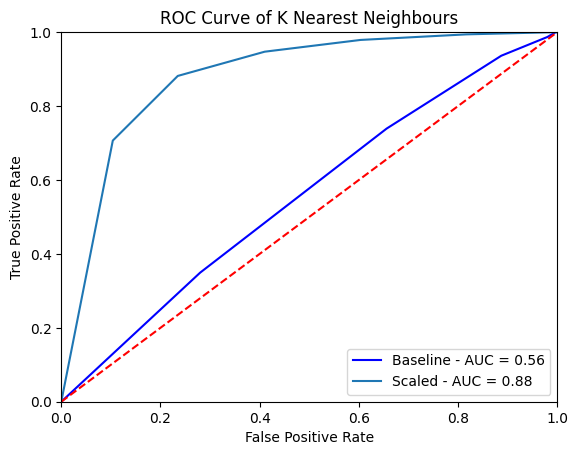

In [6]:
X_train1, X_test1, y_train1, y_test1 = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
KNN1 = KNeighborsClassifier()
KNN1.fit(X_train1, y_train1)
y_pred_baseline1 = KNN1.predict(X_test1)
y_scores1 = KNN1.predict_proba(X_test1)
fpr1, tpr1, threshold1 = roc_curve(y_test1, y_scores1[:,1])
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

This second model is an obvious improvement to our first model.

## Curse of Dimensionality

A commonly-faced problem with K Nearest Neighbours models is the curse of dimensionality. In essence, this means that as the number of features/dimensions increase, the volume of the feature space grows exponentially. This leads to data becoming sparser in higher dimensions. This affects the performance of KNN as higher dimensions means that distances become more uniform and so it is harder to determine where a new point belongs as the distances to its neighbours become similar.

We can carry out the following two dimensionality reduction techniques to try and lessen the effects of the curse of dimensionality:
* PCA (Principal Component Analysis) - A dimension reduction technique that projects the data onto a different coordinate space while maximising variance 
* LDA (Linear Discriminant Analysis) - A dimension reduction technique with the goal of maximising the distance between classes and minimsing the distance inside each class all while reducing dimensions

Furthermore, we have some nonlinear dimension reduction technique. This is sometimes called manifold learning: 
* Isomap (Isometric Mapping)
* LLE (Locally Linear Embedding)

These methods all have their pros and cons but we will try them out to see how they compare against each other.

### PCA

We perform PCA and do a search to find the best argument for the `n_components` argument.

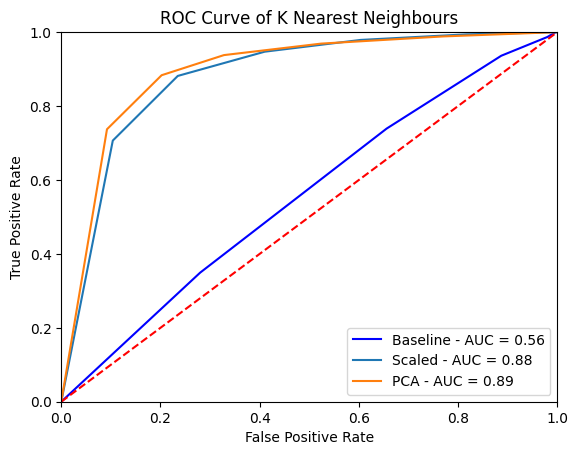

In [7]:
max_roc_auc2 = [0, 0]
for i in range(1, 20):
    pca = PCA(n_components = i)
    X_pca = pca.fit_transform(X)

    X_train2, X_test2, y_train2, y_test2 = sklearn.model_selection.train_test_split(X_pca, y, test_size = 0.20, random_state = 5)
    KNN2 = KNeighborsClassifier()
    KNN2.fit(X_train2, y_train2)
    y_pred_baseline2 = KNN2.predict(X_test2)
    y_scores2 = KNN2.predict_proba(X_test2)
    fpr2, tpr2, threshold2 = roc_curve(y_test2, y_scores2[:,1])
    roc_auc2 = auc(fpr2, tpr2)
    if roc_auc2 > max_roc_auc2[0]:
        max_roc_auc2 = (roc_auc2, i)

pca = PCA(n_components = max_roc_auc2[1])
X_pca = pca.fit_transform(X)

X_train2, X_test2, y_train2, y_test2 = sklearn.model_selection.train_test_split(X_pca, y, test_size = 0.20, random_state = 5)
KNN2 = KNeighborsClassifier()
KNN2.fit(X_train2, y_train2)
y_pred_baseline2 = KNN2.predict(X_test2)
y_scores2 = KNN2.predict_proba(X_test2)
fpr2, tpr2, threshold2 = roc_curve(y_test2, y_scores2[:,1])
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, label = 'PCA - AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

### LDA

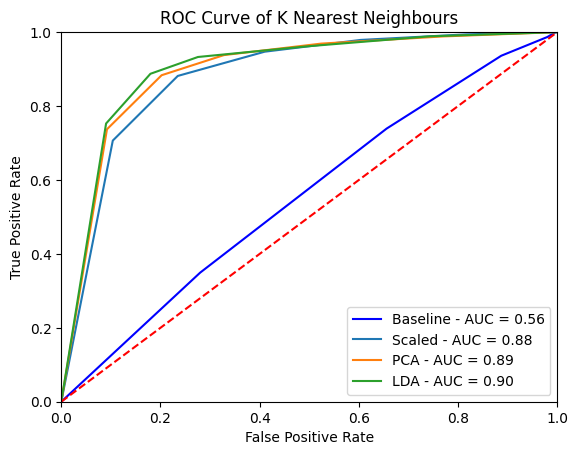

In [8]:
lda = LinearDiscriminantAnalysis() 
lda = lda.fit(X, y)
X_lda = lda.transform(X)

X_train3, X_test3, y_train3, y_test3 = sklearn.model_selection.train_test_split(X_lda, y, test_size = 0.20, random_state = 5)
KNN3 = KNeighborsClassifier()
KNN3.fit(X_train3, y_train3)
y_pred_baseline3 = KNN3.predict(X_test3)
y_scores3 = KNN3.predict_proba(X_test3)
fpr3, tpr3, threshold3 = roc_curve(y_test3, y_scores3[:,1])
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, label = 'PCA - AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, label = 'LDA - AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

### Isomap

The isomap dimension reduction technique takes a while to run so we only run it for one parameter choice of `n_components`.

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


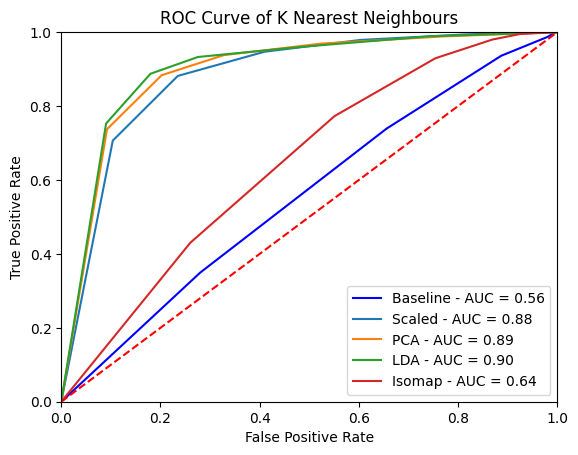

In [14]:
embedding = Isomap()
X_isomap = embedding.fit_transform(X)

X_train4, X_test4, y_train4, y_test4 = sklearn.model_selection.train_test_split(X_isomap, y, test_size = 0.20, random_state = 5)
KNN4 = KNeighborsClassifier()
KNN4.fit(X_train4, y_train4)
y_pred_baseline4 = KNN4.predict(X_test4)
y_scores4 = KNN4.predict_proba(X_test4)
fpr4, tpr4, threshold4 = roc_curve(y_test4, y_scores4[:,1])
roc_auc4 = auc(fpr4, tpr4)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, label = 'PCA - AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, label = 'LDA - AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, label = 'Isomap - AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

### LLE

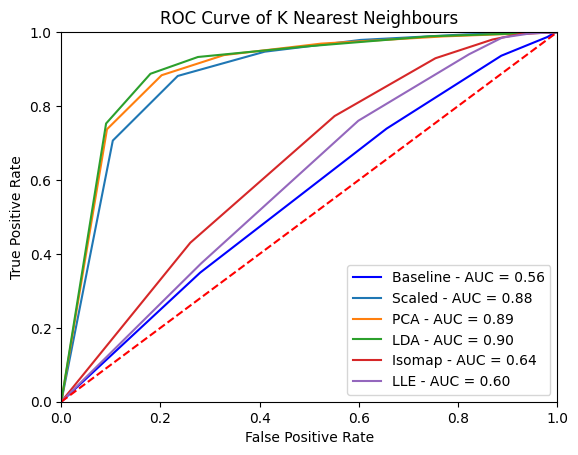

In [15]:
embedding = LocallyLinearEmbedding()
X_lle = embedding.fit_transform(X)

X_train5, X_test5, y_train5, y_test5 = sklearn.model_selection.train_test_split(X_lle, y, test_size = 0.20, random_state = 5)
KNN5 = KNeighborsClassifier()
KNN5.fit(X_train5, y_train5)
y_pred_baseline5 = KNN5.predict(X_test5)
y_scores5 = KNN5.predict_proba(X_test5)
fpr5, tpr5, threshold5 = roc_curve(y_test5, y_scores5[:,1])
roc_auc5 = auc(fpr5, tpr5)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, label = 'PCA - AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, label = 'LDA - AUC = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, label = 'Isomap - AUC = %0.2f' % roc_auc4)
plt.plot(fpr5, tpr5, label = 'LLE - AUC = %0.2f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

Looking at the ROC curves and the AUC metrics, it is clear that the nonlinear dimension reduction techniques did not work well for our purpose. We will proceed with the data, `X_lda`, once LDA was applied because it yielded the best AUC metric.

## Grid Search

There are quite a few more parameters and hyperparameters that we can tweak to improve the performance of our model. These include 

In [11]:
grid_search_KNN = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid={'n_neighbors': (1,10, 1),
                'leaf_size': (20,40,1),
                'p': (1,2),
                'weights': ('uniform', 'distance'),
                'metric': ('minkowski', 'chebyshev', 'cityblock', 'cosine', 'euclidean',
                        'l1', 'l2', 'manhattan', 'nan_euclidean'),
            },           
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5
)

grid_search_KNN.fit(X_lda, y)
print(grid_search_KNN.best_score_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_estimator_)

0.9146198995045003
{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1)


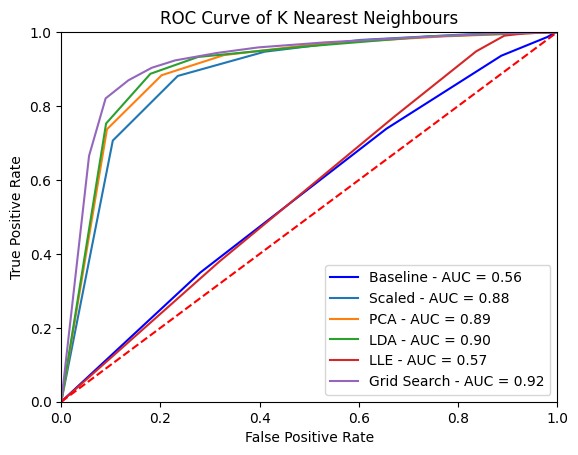

In [12]:
X_train6, X_test6, y_train6, y_test6 = sklearn.model_selection.train_test_split(X_lda, y, test_size = 0.20, random_state = 5)
KNN6 = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1)
KNN6.fit(X_train6, y_train6)
y_pred_baseline6 = KNN6.predict(X_test6)
y_scores6 = KNN6.predict_proba(X_test6)
fpr6, tpr6, threshold6 = roc_curve(y_test6, y_scores6[:,1])
roc_auc6 = auc(fpr6, tpr6)

plt.plot(fpr, tpr,'b', label = 'Baseline - AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, label = 'Scaled - AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, label = 'PCA - AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, label = 'LDA - AUC = %0.2f' % roc_auc3)
# plt.plot(fpr4, tpr4, label = 'Isomap - AUC = %0.2f' % roc_auc4)
plt.plot(fpr5, tpr5, label = 'LLE - AUC = %0.2f' % roc_auc5)
plt.plot(fpr6, tpr6, label = 'Grid Search - AUC = %0.2f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of K Nearest Neighbours')
plt.show()

In [13]:
print(classification_report(y_test, y_pred_baseline6))
print('Accuracy Score - KNN - Default:', metrics.accuracy_score(y_test, y_pred_baseline6))  

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1107
           1       0.94      0.92      0.93      4117

    accuracy                           0.89      5224
   macro avg       0.83      0.85      0.84      5224
weighted avg       0.89      0.89      0.89      5224

Accuracy Score - KNN - Default: 0.8910796324655437
